In [1]:
def matrix_norm(A, norm = 1):
    if norm == 1:
        return np.max(np.sum(np.abs(A), axis = 0));
    elif norm == 2:
        _, s, _ = np.linalg.svd(A)
        return np.max(s);
        #return np.sum(np.sum(A**2, axis = 0)**0.5);
    elif norm == 'frob':
        return (np.sum(A**2))**0.5;
    elif norm == "inf":
        return np.max(np.sum(np.abs(A), axis = 1));

def Condition_number(A, inv_A = 'null', norm = 1):
    if inv_A == 'null':
        inv_A = np.linalg.pinv(A);
    return matrix_norm(A, norm = norm) * matrix_norm(inv_A, norm = norm);

In [2]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

Mounted at /content/drive


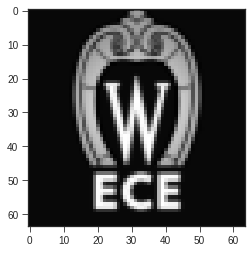

In [3]:
import numpy as np;
import matplotlib.pyplot as plt;
import matplotlib.image as mpimg;
plt.style.use(['seaborn-ticks'])
#plt.style.use(['classic'])

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

r = 64;
c = 64;

#########################################################
ratio_val = 0. ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################

error = [];

pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = False, size = (r,c), anti_aliasing = False);

---
Before mask constant


In [4]:
N = 20;
R_max = 0.7;

Ratio_list = np.arange(N)/(N-1) * R_max;
percentage = [];
SNR_theo = [];

cond_BMC = {1:[], 2:[], 'frob': [], 'inf':[]};

light_level = 2;
pmt.img_tensor = pmt.img_tensor * light_level;

cond = cond_BMC;
for i in range(len(Ratio_list)):
    print("%d / %d" %(i,len(Ratio_list)));

    ratio_val = Ratio_list[i];

    pmt.Make_DMD_basis(r*c, scan_mode='Basis', ratio = ratio_val);
    DMD = pmt.DMD_basis;
    DMD_inv = np.linalg.pinv(DMD);
    print(np.mean(DMD.dot(DMD_inv) - np.eye(r*c)));
    percentage.append(np.mean(DMD));
    #print("The percentage of ones in maks is %.3e"%np.mean(DMD));

    ## Theory
    noiseless_measure = pmt.PMT_measure_simu(1, r*c, Poisson=False, upload_DMD_basis=DMD);
    covar_noiseless = (DMD_inv.dot(np.diag(noiseless_measure.reshape((-1,))))).dot(DMD_inv.T);
    SNR_theo.append(pmt.img_tensor[:,:,0].reshape(-1,)/np.diag(covar_noiseless)**0.5);    

    ## condition number
    for norm in cond:
        
        val = Condition_number(DMD, DMD_inv, norm);
        print(norm, val)
        cond[norm].append(val);

0 / 20
3.4095843077767685e-19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


1 12283.999999999187
2 2051.383807597936
frob 8968.532658299302
inf 13235.724717380652
1 / 20
4.526851829933926e-19
1 248112.74696773302
2 3809.3562839737715
frob 15560.308361135723
inf 22128.486666718713
2 / 20
-1.0483047928196824e-19
1 407901.8805881162
2 7346.767475521966
frob 24654.21372850737
inf 25355.781400707656
3 / 20
-2.9594350965515024e-19
1 180595.09341779948
2 2963.556580761205
frob 13278.365885679721
inf 17233.254321598568
4 / 20
2.360860653739431e-18
1 95131.39396295126
2 1697.4354691922656
frob 9273.595975586515
inf 14575.213411552795
5 / 20
6.724758078973191e-20
1 98492.31265092918
2 1708.743084413735
frob 9899.508147917031
inf 15259.100170376676
6 / 20
-1.235050975148929e-19
1 192999.50515286328
2 4144.964680262272
frob 12972.906108908097
inf 17040.69827688107
7 / 20
-1.4694306821648116e-19
1 90991.61591073376
2 1556.823838874244
frob 9693.93499807093
inf 15630.552102688762
8 / 20
1.0072955965232892e-18
1 84878.35736780967
2 1496.72466750329
frob 9497.645207830526
inf

No handles with labels found to put in legend.


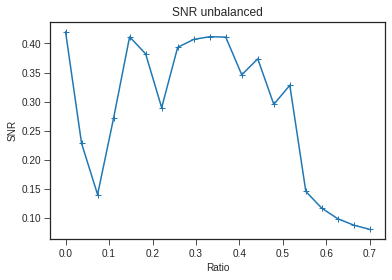

In [5]:
SNR_mean = [];
for SNR in SNR_theo:
    SNR_mean.append(np.mean(SNR));

plt.figure();
plt.plot(Ratio_list, (SNR_mean), Marker = '+');
plt.xlabel('Ratio');
plt.ylabel('SNR');
plt.title("SNR unbalanced");
plt.legend();
plt.show();

No handles with labels found to put in legend.


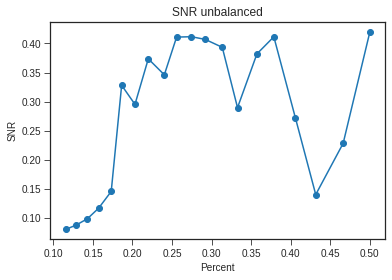

In [6]:
SNR_mean = [];
for SNR in SNR_theo:
    SNR_mean.append(np.mean(SNR));

plt.figure();
plt.plot(percentage, (SNR_mean), Marker = 'o');
plt.xlabel('Percent');
plt.ylabel('SNR');
plt.title("SNR unbalanced");
plt.legend();
plt.show();

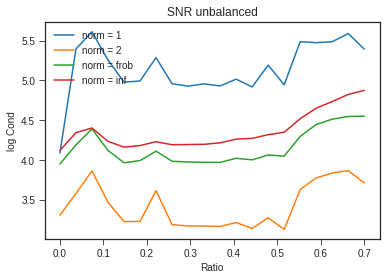

In [7]:
plt.figure();
for norm in cond:
    plt.plot(Ratio_list, np.log10(cond_BMC[norm]), label = "norm = %s"%(norm));
plt.xlabel('Ratio');
plt.ylabel('log Cond');
plt.title("SNR unbalanced");
plt.legend();
plt.show();

---
After Mask constant

In [8]:
N = 20;
R_max = 0.7;

Ratio_list = np.arange(N)/(N-1) * R_max;
percentage = [];
SNR_theo = [];

cond_AMC = {1:[], 2:[], 'frob': [], 'inf':[]}

cond = cond_AMC;

for i in range(len(Ratio_list)):
    print("%d / %d" %(i,len(Ratio_list)));

    ratio_val = Ratio_list[i];

    pmt.Make_DMD_basis(r*c, scan_mode='Basis', ratio = ratio_val);
    DMD = pmt.DMD_basis;
    DMD_inv = np.linalg.pinv(DMD);

    light_level = 2 * 0.5/np.mean(DMD);
    pmt.img_tensor = pmt.img_tensor * light_level;      
    
    print(np.mean(DMD.dot(DMD_inv) - np.eye(r*c)));
    percentage.append(np.mean(DMD));
    #print("The percentage of ones in maks is %.3e"%np.mean(DMD));

    ## Theory
    noiseless_measure = pmt.PMT_measure_simu(1, r*c, Poisson=False, upload_DMD_basis=DMD);
    covar_noiseless = (DMD_inv.dot(np.diag(noiseless_measure.reshape((-1,))))).dot(DMD_inv.T);
    SNR_theo.append(pmt.img_tensor[:,:,0].reshape(-1,)/np.diag(covar_noiseless)**0.5);  

    pmt.img_tensor = pmt.img_tensor / light_level; 

    for norm in cond:
        cond[norm].append(Condition_number(DMD, DMD_inv, norm));

0 / 20
3.4095843077767685e-19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


1 / 20
4.526851829933926e-19
2 / 20
-1.0483047928196824e-19
3 / 20
-2.9594350965515024e-19
4 / 20
2.360860653739431e-18
5 / 20
6.724758078973191e-20
6 / 20
-1.235050975148929e-19
7 / 20
-1.4694306821648116e-19
8 / 20
1.0072955965232892e-18
9 / 20
3.181573469997073e-18
10 / 20
6.612302238161587e-18
11 / 20
3.3331509551821905e-18
12 / 20
9.480601637637705e-19
13 / 20
-2.765019576542378e-18
14 / 20
2.538061272440424e-19
15 / 20
1.5660622855837332e-18
16 / 20
3.0478666207482987e-18
17 / 20
-6.491164570226232e-19
18 / 20
5.623503873426105e-20
19 / 20
3.9773001741822424e-19


No handles with labels found to put in legend.


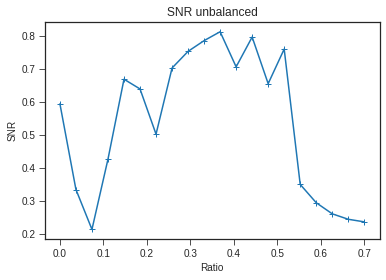

In [9]:
SNR_mean = [];
for SNR in SNR_theo:
    SNR_mean.append(np.mean(SNR));

plt.figure();
plt.plot(Ratio_list, (SNR_mean), Marker = '+');
plt.xlabel('Ratio');
plt.ylabel('SNR');
plt.title("SNR unbalanced");
plt.legend();
plt.show();

No handles with labels found to put in legend.


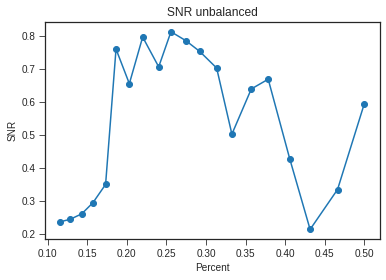

In [10]:
SNR_mean = [];
for SNR in SNR_theo:
    SNR_mean.append(np.mean(SNR));

plt.figure();
plt.plot(percentage, (SNR_mean), Marker = 'o');
plt.xlabel('Percent');
plt.ylabel('SNR');
plt.title("SNR unbalanced");
plt.legend();
plt.show();

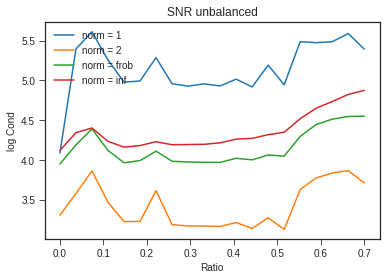

In [13]:
plt.figure();
for norm in cond:    
    plt.plot(Ratio_list, np.log10(cond_AMC[norm]), label = "norm = %s"%(norm));
plt.xlabel('Ratio');
plt.ylabel('log Cond');
plt.title("SNR unbalanced");
plt.legend();
plt.show();

In [ ]:
len(cond[1])